In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import LabelEncoder

In [ ]:
data=pd.read_csv('data1.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
df=data.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373027 entries, 0 to 373026
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    373027 non-null  object 
 1   StockCode    373027 non-null  object 
 2   Description  371767 non-null  object 
 3   Quantity     373027 non-null  int64  
 4   InvoiceDate  373027 non-null  object 
 5   UnitPrice    373027 non-null  float64
 6   CustomerID   274963 non-null  float64
 7   Country      373026 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 22.8+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,373027.000000,373027.000000,274963.000000
mean,9.798143,4.775055,15278.829428
std,180.865557,106.654277,1717.349266
min,-74215.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13875.000000
50%,3.000000,2.100000,15150.000000
75%,10.000000,4.130000,16788.000000
max,74215.000000,38970.000000,18287.000000


In [ ]:
#checking for duplicates
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12-01-2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12-01-2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12-01-2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12-01-2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12-01-2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
372240,569234,22326,ROUND SNACK BOXES SET OF4 WOODLAND,1,10-02-2011 15:33,2.95,17841.0,United Kingdom
372244,569234,23203,JUMBO BAG VINTAGE DOILY,1,10-02-2011 15:33,2.08,17841.0,United Kingdom
372450,569243,23294,SET OF 6 SNACK LOAF BAKING CASES,8,10-03-2011 09:44,0.83,13344.0,United Kingdom
372451,569243,23294,SET OF 6 SNACK LOAF BAKING CASES,8,10-03-2011 09:44,0.83,13344.0,United Kingdom


In [ ]:
#checking null values
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1260
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,98064
Country,1


In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
df.isna().sum().sum()

0

In [ ]:
new_df=df.copy()


In [ ]:
new_df['Amount']=new_df['Quantity']*new_df['UnitPrice']
new_df = new_df.drop(columns=['Quantity', 'UnitPrice'])
label_encoder = LabelEncoder()
new_df['Country'] = label_encoder.fit_transform(new_df['Country'])
new_df['StockCode'] = label_encoder.fit_transform(new_df['StockCode'])

In [ ]:
new_df['InvoiceDate'] = pd.to_datetime(new_df['InvoiceDate'], format='mixed', dayfirst=True)
reference_date = new_df['InvoiceDate'].max()
new_df['Recency'] = (reference_date - new_df['InvoiceDate']).dt.days
recency_per_customer = new_df.groupby('CustomerID')['Recency'].min().reset_index()
new_df = new_df.merge(recency_per_customer, on='CustomerID', suffixes=('_original', ''))

In [ ]:
print(len(new_df['CustomerID'].unique()))

3668


In [ ]:
recency_per_customer = new_df.groupby('CustomerID')['Recency'].min().reset_index()
frequency_per_customer = new_df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_per_customer.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
monetary_per_customer = new_df.groupby('CustomerID')['Amount'].sum().reset_index()
monetary_per_customer.rename(columns={'Amount': 'MonetaryValue'}, inplace=True)
customer_data = recency_per_customer.merge(frequency_per_customer, on='CustomerID')
customer_data = customer_data.merge(monetary_per_customer, on='CustomerID')
country_per_customer = new_df.groupby('CustomerID')['Country'].agg(lambda x: x.value_counts().index[0]).reset_index()
country_per_customer.rename(columns={'Country': 'ModeCountry'}, inplace=True)

stockcode_per_customer = new_df.groupby('CustomerID')['StockCode'].agg(lambda x: x.value_counts().index[0]).reset_index()
stockcode_per_customer.rename(columns={'StockCode': 'ModeStockCode'}, inplace=True)

#Merge Country and StockCode into Customer Data
customer_data = customer_data.merge(country_per_customer, on='CustomerID')
customer_data = customer_data.merge(stockcode_per_customer, on='CustomerID')


In [ ]:
customer_data.head()

,CustomerID,Recency,Frequency,MonetaryValue,ModeCountry,ModeStockCode
0,12346.0,325,2,0.00,34,1999
1,12347.0,94,124,2790.86,16,1248
2,12348.0,75,31,1797.24,12,3538
3,12350.0,310,17,334.40,24,874
4,12352.0,72,80,1233.68,24,3536


/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


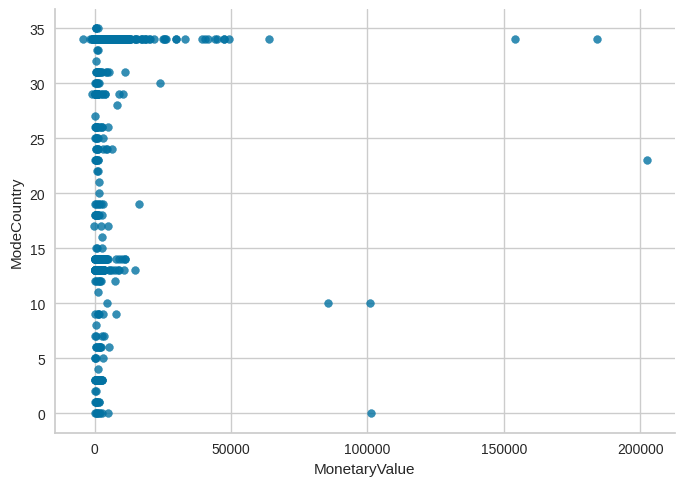

In [ ]:
# @title MonetaryValue vs ModeCountry

from matplotlib import pyplot as plt
customer_data.plot(kind='scatter', x='MonetaryValue', y='ModeCountry', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


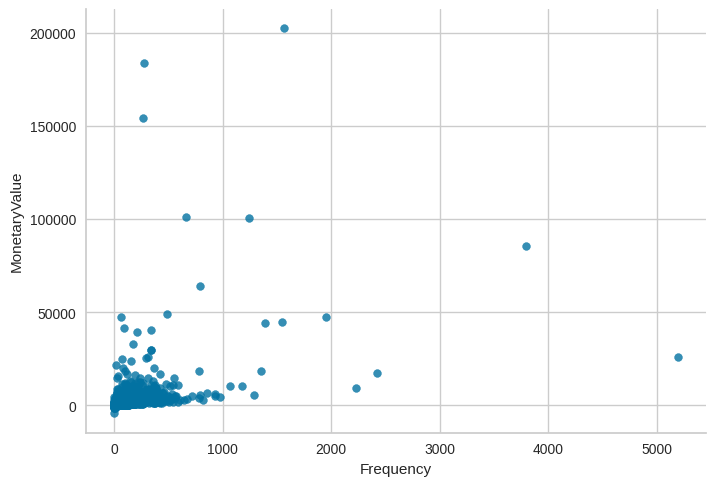

In [ ]:
# @title Frequency vs MonetaryValue

from matplotlib import pyplot as plt
customer_data.plot(kind='scatter', x='Frequency', y='MonetaryValue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3668 entries, 0 to 3667
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3668 non-null   float64
 1   Recency        3668 non-null   int64  
 2   Frequency      3668 non-null   int64  
 3   MonetaryValue  3668 non-null   float64
 4   ModeCountry    3668 non-null   int64  
 5   ModeStockCode  3668 non-null   int64  
 6   Cluster        3668 non-null   int32  
dtypes: float64(2), int32(1), int64(4)
memory usage: 186.4 KB


In [ ]:
new_df.head()

,InvoiceNo,StockCode,CustomerID,Country,Amount,Recency
0,536365,3130,17850.0,34,15.30,68
1,536365,2536,17850.0,34,20.34,68
2,536365,2737,17850.0,34,22.00,68
3,536365,2686,17850.0,34,20.34,68
4,536365,2685,17850.0,34,20.34,68


In [ ]:
X = customer_data[['Recency', 'Frequency', 'MonetaryValue', 'ModeCountry', 'ModeStockCode']]


# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)

In [ ]:
X

,Recency,Frequency,MonetaryValue,ModeCountry,ModeStockCode
0,325,2,0.00,34,1999
1,94,124,2790.86,16,1248
2,75,31,1797.24,12,3538
3,310,17,334.40,24,874
4,72,80,1233.68,24,3536
...,...,...,...,...,...
3663,159,10,180.60,34,2661
3664,3,7,80.82,34,942
3665,92,8,98.76,34,2020
3666,148,447,1120.67,34,891


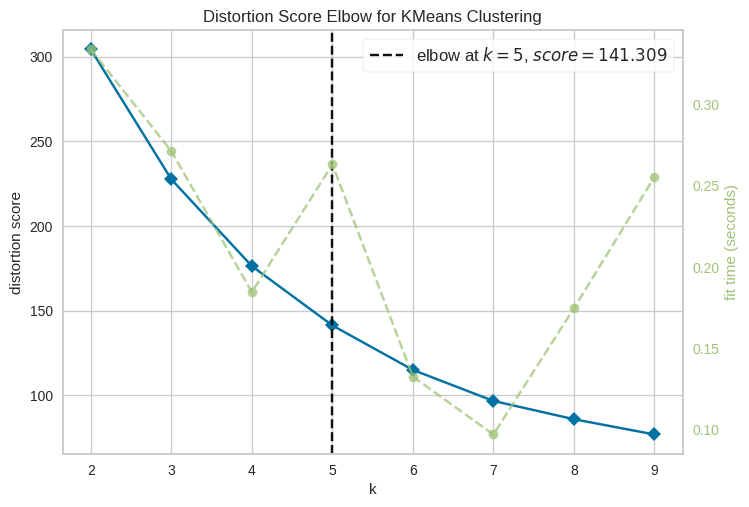

In [ ]:
model = KMeans(random_state=42,n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(scaled_features)
visualizer.show()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)
customer_data.head()

,CustomerID,Recency,Frequency,MonetaryValue,ModeCountry,ModeStockCode,Cluster
0,12346.0,325,2,0.00,34,1999,4
1,12347.0,94,124,2790.86,16,1248,3
2,12348.0,75,31,1797.24,12,3538,3
3,12350.0,310,17,334.40,24,874,4
4,12352.0,72,80,1233.68,24,3536,2


In [ ]:
cluster_profiles = customer_data.groupby('Cluster').mean()
print(cluster_profiles)

           CustomerID     Recency  Frequency  MonetaryValue  ModeCountry  \
Cluster                                                                    
0        15563.851519  117.746907  72.220472    1273.600800    33.857143   
1        15410.345210   90.292953  83.992874    2089.484158    33.839272   
2        15401.448319  127.229141  87.322540    1546.447498    33.719801   
3        12860.804000  124.868000  92.688000    2862.740800    11.064000   
4        15458.868251  367.250540  24.587473     325.892981    33.580994   

         ModeStockCode  
Cluster                 
0           566.911136  
1          1596.527316  
2          2884.379826  
3          2000.136000  
4          1368.680346  


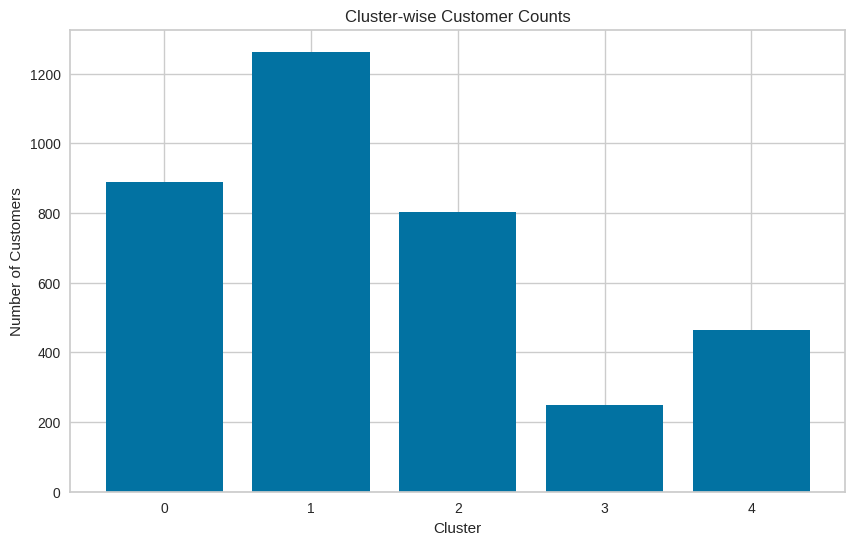

In [ ]:
# prompt: draw a bar graph cluster wise customers count

import matplotlib.pyplot as plt

# Assuming 'customer_data' DataFrame is already created as in your provided code

cluster_counts = customer_data['Cluster'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Cluster-wise Customer Counts')
plt.xticks(cluster_counts.index)  # Ensure all cluster labels are displayed
plt.show()


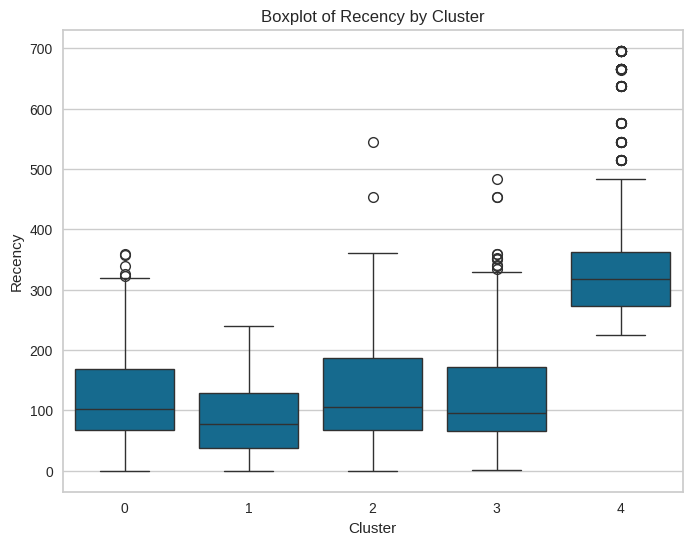

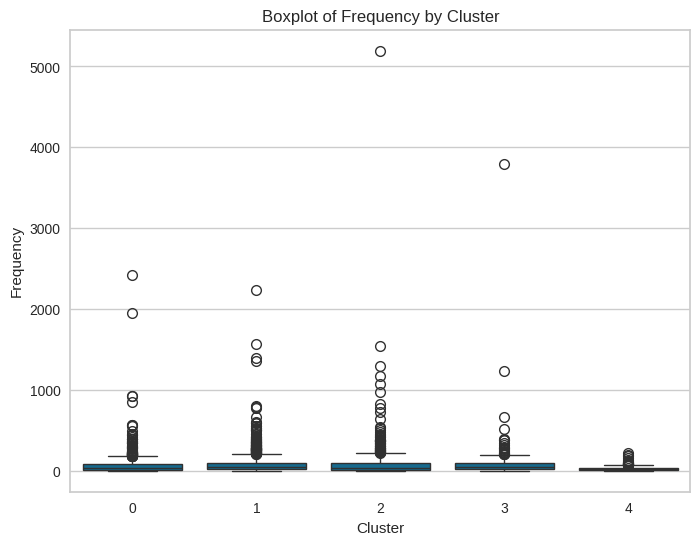

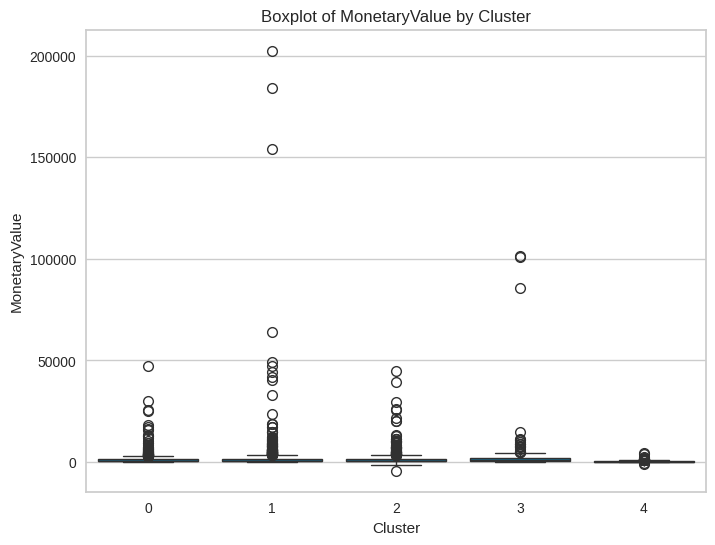

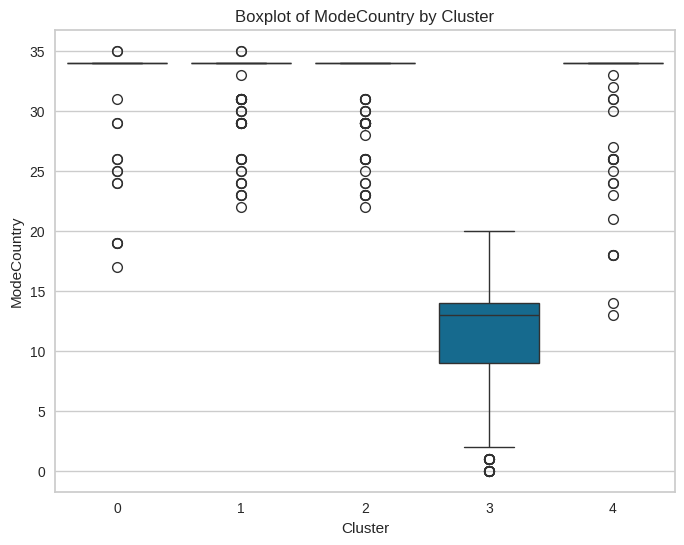

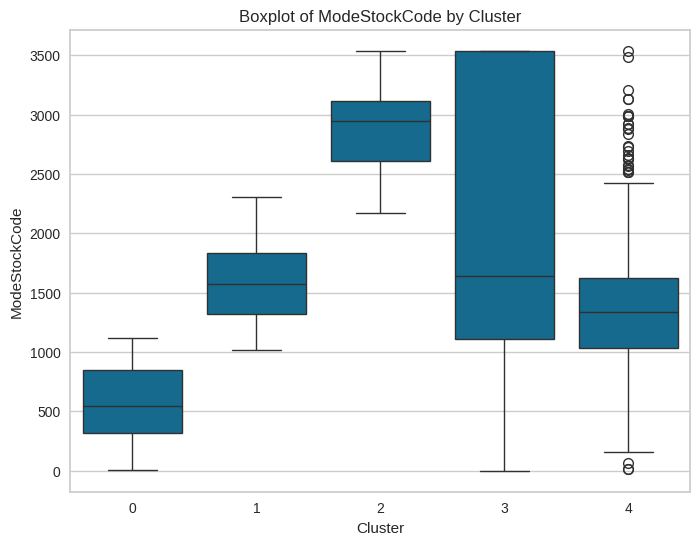

In [ ]:
for col in ['Recency', 'Frequency', 'MonetaryValue', 'ModeCountry', 'ModeStockCode']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=col, data=customer_data)
    plt.title(f'Boxplot of {col} by Cluster')
    plt.show()

In [ ]:
silhouette_avg = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3810566182440664


Explanation of the Clusters

1. "VIP Product Lovers"

Business Interpretation: Loyal customers who frequently purchase high-value products within a specific product category.
Business Actions:
Loyalty Programs: Create a tiered loyalty program with exclusive benefits, such as early access to sales, personalized discounts, and free gifts.
Personalized Communication: Use their preferred product categories to send highly relevant product recommendations and content.
Upselling and Cross-selling: Offer higher-end products in their product category or related products.
Dedicated Support: Provide a dedicated support channel or account manager to address their needs promptly.
Feedback Loops: Actively seek their feedback on new products and services and involve them in product development.
2. "Lost Causes"

Business Interpretation: Infrequent, low-spending customers with high recency.
Business Actions:
Re-engagement Campaigns: Send targeted emails with enticing offers, such as discounts, free shipping, or exclusive deals.
Win-Back Incentives: Offer a special incentive for their next purchase, such as a free gift or a higher discount for first purchase.
Feedback Surveys: If possible, conduct a survey to understand why they stopped engaging.
Content Engagement: Send personalized content, product reviews, blog posts, etc.
3. "Regular Purchasers"

Business Interpretation: Average customers with moderate frequency and spending.
Business Actions:
Personalized Recommendations: Use purchase history to suggest relevant products.
Cross-selling: Introduce them to new categories or related products they haven't tried yet.
Loyalty Program Enrollment: Encourage them to join your loyalty program to increase engagement and spending.
Targeted Promotions: Run personalized promotions based on their preferences to encourage repeat purchases.
Upselling: Try to push higher value products to these customers.
4. "Frequent Low Spenders"

Business Interpretation: Frequent shoppers with high engagement but low spending. Value-conscious customers purchasing low-value items.
Business Actions:
Product Bundles: Create appealing bundles that combine lower-priced items to increase their average order value.
Cross-selling Campaigns: Recommend higher-margin products or related items that they might be interested in.
Promotions for Higher Value Items: Offer promotions for larger orders, or higher priced products.
5. "Big Spenders (Infrequent)"

Business Interpretation: Customers who have made very high-value purchases but do so infrequently, and in a particular product category.
Business Actions:
Personalized Follow Ups: Reach out to them via a personal message to thank them for their purchase and follow up to address any issues.
Exclusive Promotions: Target them with offers for similar high-value products.
Personalized Recommendations: Offer personalized recommendations of similar or related products.
Re-engagement: Launch targeted re-engagement campaigns to get them to purchase again.